In [8]:
! wget -q https://covid.ourworldindata.org/data/owid-covid-data.csv

In [93]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm

import pandas as pd
import gc
import datetime
from sklearn.preprocessing import MinMaxScaler

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (12,6)
legend_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('text', usetex=True)
rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
rc('text.latex',preamble=r'\usepackage[russian]{babel}')
rc('figure', **{'dpi': 200})

In [94]:
mpl.rcParams.update(mpl.rcParamsDefault)

# Task 1

Скачайте данные, выберите данные по России, начиная с 3 марта 2020 г.

In [214]:
RUS_START_DATE = datetime.datetime(2020, 3, 3)

In [215]:
# Read and preprocess dataset
df = pd.read_csv('owid-covid-data.csv')
df["date"] = pd.to_datetime(df.date)
columns = ['iso_code', 'date', 'total_cases', 'new_cases']
df = df[columns]
gc.collect()
df = df[(df['iso_code'] == 'RUS') & (df['date'] >= RUS_START_DATE)].reset_index(drop=True)
df.sort_values("date", inplace=True, ignore_index=True, ascending=True)
df.drop(df.tail(3).index, inplace=True)
df.loc[df.new_cases <= 0, "new_cases"] = 1

df["log_total_cases"] = np.log(df.total_cases)
df["log_new_cases"] = np.log(df.new_cases)
df["num_days"] = df.index.values # Num days from START_DATE
days_scaler = MinMaxScaler()
df["norm_num_days"] = days_scaler.fit_transform(df[["num_days"]])
df["sq_norm_num_days"] = df.norm_num_days ** 2

df.head(5)

,iso_code,date,total_cases,new_cases,log_total_cases,log_new_cases,num_days,norm_num_days,sq_norm_num_days
0,RUS,2020-03-03,3.0,1.0,1.098612,0.0,0,0.00000,0.000000e+00
1,RUS,2020-03-04,3.0,1.0,1.098612,0.0,1,0.00091,8.279510e-07
2,RUS,2020-03-05,3.0,1.0,1.098612,0.0,2,0.00182,3.311804e-06
3,RUS,2020-03-06,4.0,1.0,1.386294,0.0,3,0.00273,7.451559e-06
4,RUS,2020-03-07,4.0,1.0,1.386294,0.0,4,0.00364,1.324722e-05


Зафиксируем тренировочный набор в виде первых 50 отсчётов (дней), начиная с 3 марта; остальные данные можно использовать в качестве тестового набора

In [216]:
# Split dataset to train/test
df_train = df[:50]
df_test = df[50:]
print("Total shape:", df.shape)
print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)

Total shape: (1100, 9)
Train shape: (50, 9)
Test shape: (1050, 9)


# Task 2

Постройте графики целевых переменных: total_cases и new_cases

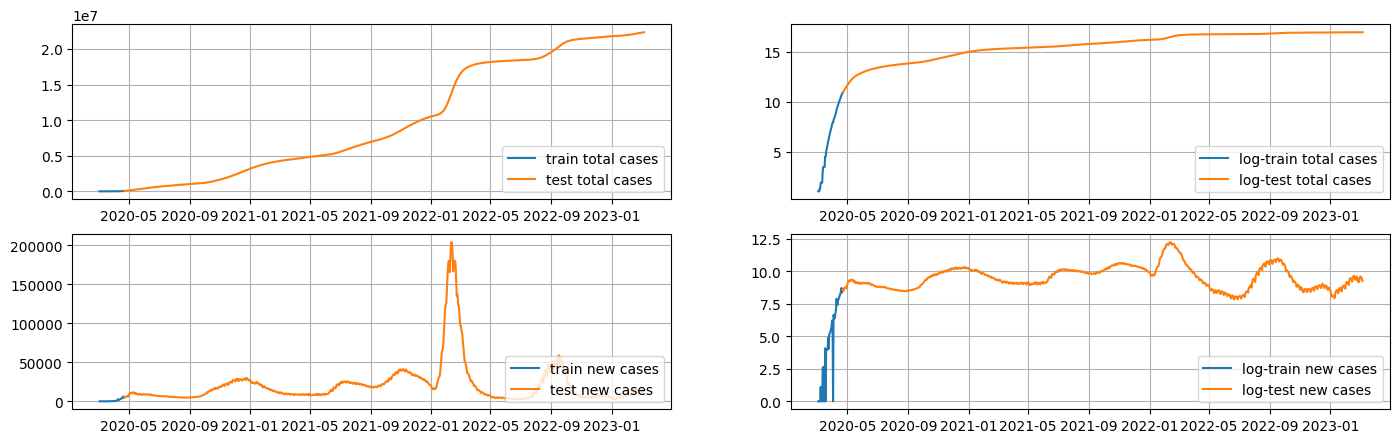

In [107]:
# Total cases and New cases graphs
_, ax = plt.subplots(2, 2, figsize=(17, 5))
ax[0][0].plot(df_train.date, df_train['total_cases'], label="train total cases")
ax[0][0].plot(df_test.date, df_test['total_cases'], label="test total cases")
ax[0][0].grid()
ax[0][0].legend(loc="lower right")
ax[0][1].plot(df_train.date, np.log(df_train['total_cases']), label="log-train total cases")
ax[0][1].plot(df_test.date, np.log(df_test['total_cases']), label="log-test total cases")
ax[0][1].grid()
ax[0][1].legend(loc="lower right")
ax[1][0].plot(df_train.date, df_train['new_cases'], label="train new cases")
ax[1][0].plot(df_test.date, df_test['new_cases'], label="test new cases")
ax[1][0].grid()
ax[1][0].legend(loc="lower right")
ax[1][1].plot(df_train.date, np.log(df_train['new_cases']), label="log-train new cases")
ax[1][1].plot(df_test.date, np.log(df_test['new_cases']), label="log-test new cases")
ax[1][1].grid()
ax[1][1].legend(loc="lower right")
plt.show()

## a) Обучите модель с экспоненциальным ростом числа заболевших

In [151]:
# Train LinReg for total cases prediction
linreg_exp_total_cases = LinearRegression().fit(df_train[["norm_num_days"]], df_train.log_total_cases)
print(f"Training done!\ntime weight: {linreg_exp_total_cases.coef_[0]:.3f}, bias: {linreg_exp_total_cases.intercept_:.3f}")
y_pred_log = linreg_exp_total_cases.predict(df[["norm_num_days"]])
y_pred = np.exp(y_pred_log)

Training done!
time weight: 235.303, bias: 1.193


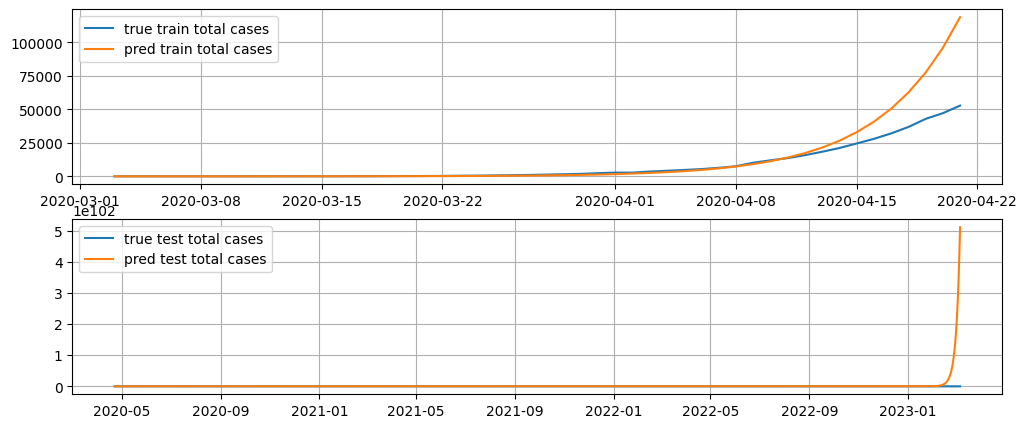

In [152]:
# Plot results
_, ax = plt.subplots(2, 1, figsize=(12, 5))
ax[0].plot(df_train.date, df_train['total_cases'], label="true train total cases")
ax[0].plot(df_train.date, y_pred[:50], label="pred train total cases")
ax[0].grid()
ax[0].legend(loc="upper left")
ax[1].plot(df_test.date, df_test['total_cases'], label="true test total cases")
ax[1].plot(df_test.date, y_pred[50:], label="pred test total cases")
ax[1].grid()
ax[1].legend(loc="upper left")
plt.show()

## b) Найдите апостериорное распределение параметров этой модели

In [153]:
def bayesian_update(mu, sigma, x, y, sigma_noise):
    x_ = np.concatenate((np.ones((len(x), 1)), x), axis=1)
    sigma_n = np.linalg.inv(np.linalg.inv(sigma_0) + (1 / sigma_noise ** 2) * np.dot(x_.T, x_))
    mu_n = np.dot(sigma_n, np.dot(np.linalg.inv(sigma_0), mu_0.T) + (1 / sigma_noise ** 2) * np.dot(x_.T, y))
    return mu_n, sigma_n

In [269]:
sigma_noise = np.std(df_train.log_total_cases - y_pred_log[:50]) # Noise variance estimation
mu_0, sigma_0 = np.zeros(2), 100 * np.eye(2) # Normal distribution as a prior of parameters
# A posterior distribution of parameters
mu_n, sigma_n = bayesian_update(mu_0, sigma_0, df_train[["norm_num_days"]], df_train.log_total_cases, sigma_noise) 

## c)

Посэмплируйте много разных экспонент, постройте графики

In [232]:
def exp_linreg(x, w, use_sq=False, sigma_noise=False):
    res = w[0] + x * w[1]
    if sigma_noise:
        res += sigma_noise
    if use_sq:
        res += x ** 2 * w[2]
        return np.cumsum(np.exp(res))
    return np.exp(res)

In [233]:
def sample_exp_linregs(sampled_weights, xs, use_sq=False):
    res = np.zeros((len(sampled_weights), xs.shape[0]))
    for sample_num, weights in enumerate(sampled_weights):
        res[sample_num, :] = exp_linreg(xs, weights, use_sq)
    return res

In [234]:
def plot_predictions(xs, mu, sample_exps, sigma_noise, use_sq=False):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    #ax.set_xlim((xs[0], xs[-1]))
    #ax.set_ylim((-2, 2))
    ax.plot(xs, df.total_cases[:len(xs)], label="Правильный ответ")
    ax.plot(xs, exp_linreg(xs, mu, use_sq), color="red", label="MAP гипотеза")
    ax.fill_between(xs, 
                    exp_linreg(xs, mu, use_sq, -sigma_noise), 
                    exp_linreg(xs, mu, use_sq, sigma_noise), 
                    color=palette[1], alpha=.3, label="+- дисперсия шума")
    ax.fill_between(xs, 
                    np.mean(sample_exps, axis=0) - np.std(sample_exps, axis=0), 
                    np.mean(sample_exps, axis=0) + np.std(sample_exps, axis=0), 
                    color=palette[5], alpha=.2, label="+- дисперсия предсказаний")
    ax.legend(fontsize=legend_fontsize)
    plt.show()

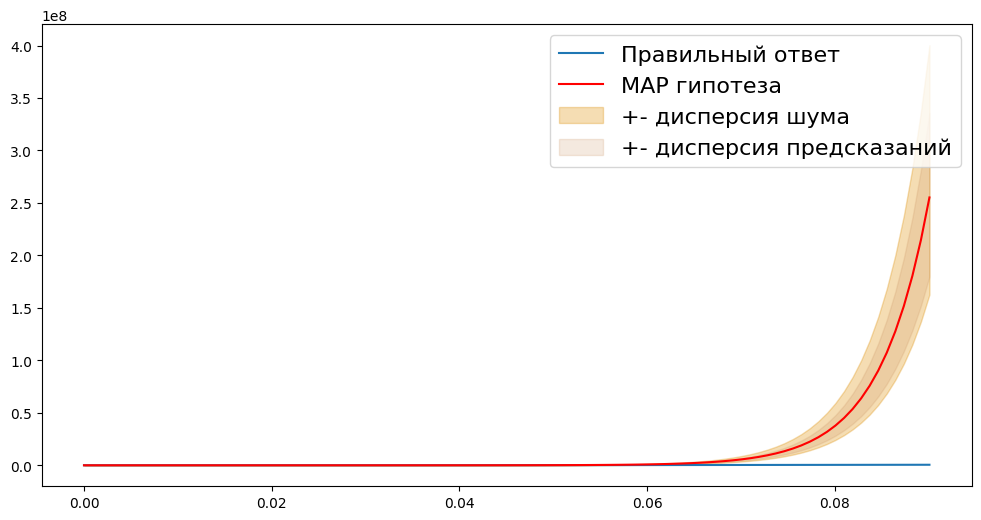

In [271]:
n_samples = 300
num_days = 100
sampled_weights = np.random.multivariate_normal(mu_n, sigma_n, n_samples)
sample_exps = sample_exp_linregs(sampled_weights, df.norm_num_days[:num_days])

plot_predictions(df.norm_num_days[:num_days], mu_n, sample_exps, sigma_noise)

Постройте предсказательные распределения

In [264]:
def predict_y_dist(date, sampled_weights):
    x = df[df.date == date].norm_num_days.item()
    return np.exp(sampled_weights.dot(np.array([[1.], [x]])))

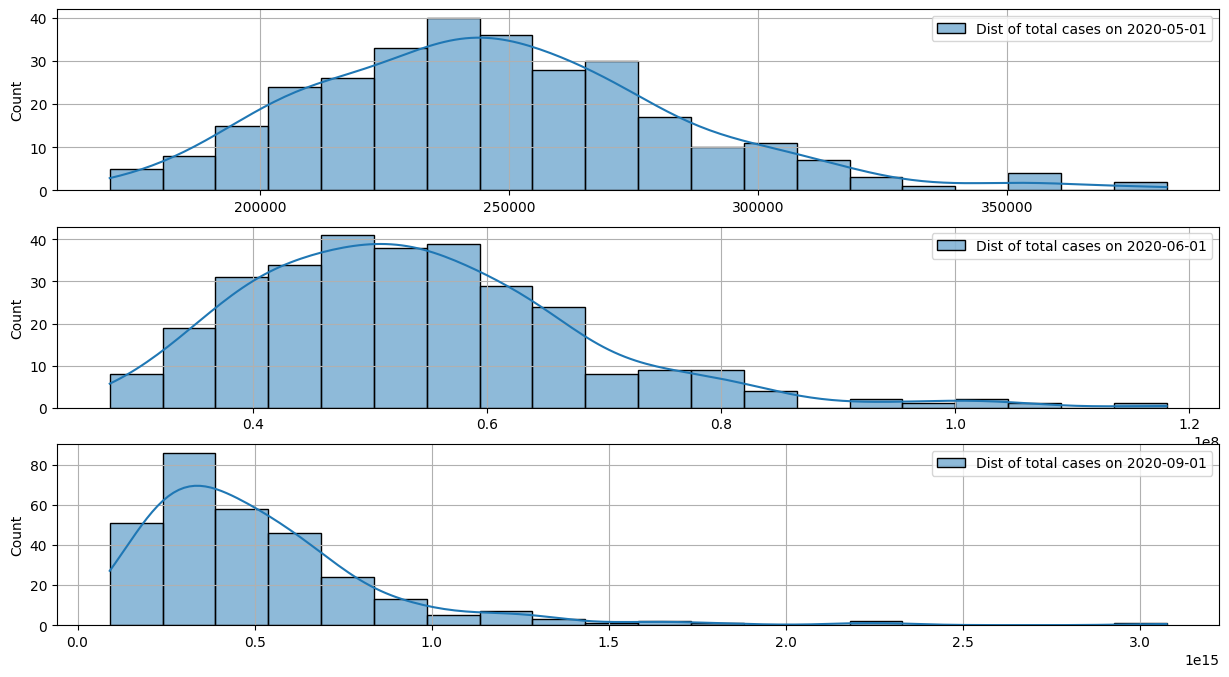

In [272]:
# Total cases and New cases graphs
_, axs = plt.subplots(3, 1, figsize=(15, 8))
date_pred = {}
for i, (date, ax) in enumerate(zip(["2020-05-01", "2020-06-01", "2020-09-01"], axs)):
    date_pred.update({date: predict_y_dist(date, sampled_weights)})
    sns.histplot(date_pred[date], ax=ax, bins=20, kde=True, label=f"Dist of total cases on {date}")
    ax.legend()
    ax.grid()
plt.show()

Сколько, исходя из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая? к 1 июня? к 1 сентября?

In [212]:
print(f"Случаев заражения в РФ к 01.05.2020: {int(np.mean(date_pred['2020-05-01']))}")
print(f"Случаев заражения в РФ к 01.06.2020: {int(np.mean(date_pred['2020-06-01']))}")
print(f"Случаев заражения в РФ к 01.09.2020: {int(np.mean(date_pred['2020-09-01']))}")

Случаев заражения в РФ к 01.05.2020: 251767
Случаев заражения в РФ к 01.06.2020: 55789678
Случаев заражения в РФ к 01.09.2020: 558131085140781


# Task 3

## a) Предложите способ обучать параметры такой сигмоидальной функции при помощи линейной регрессии

$y_{new\_cases}(x) = e^{w_2 x^2 + w_1 x + w_0}$ -- обучаем линейную регрессию на предсказание новых случаев.  
$y_{total\_cases}(d) = \int_{-∞}^d y_{new\_cases}(x)dx \approx \sum_1^d y_{new\_cases}(x_i)$ -- суммируем предсказания новых случаев до даты d для вычисления общего числа зараженных.

## b) Обучите эти параметры

In [299]:
# Train LinReg for new cases prediction
linreg_exp_new_cases = LinearRegression().fit(df_train[["norm_num_days", "sq_norm_num_days"]], df_train.log_new_cases)
print(f"Training done!\ntime weight: {linreg_exp_new_cases.coef_[0]:.3f}, "
      f"time^2 weight: {linreg_exp_new_cases.coef_[1]:.3f}, bias: {linreg_exp_new_cases.intercept_:.3f}")
new_cases_pred_log = linreg_exp_new_cases.predict(df[["norm_num_days", "sq_norm_num_days"]])
new_cases_pred = np.exp(new_cases_pred_log)
total_cases_pred = np.cumsum(new_cases_pred)

Training done!
time weight: 283.851, time^2 weight: -1437.594, bias: -0.873


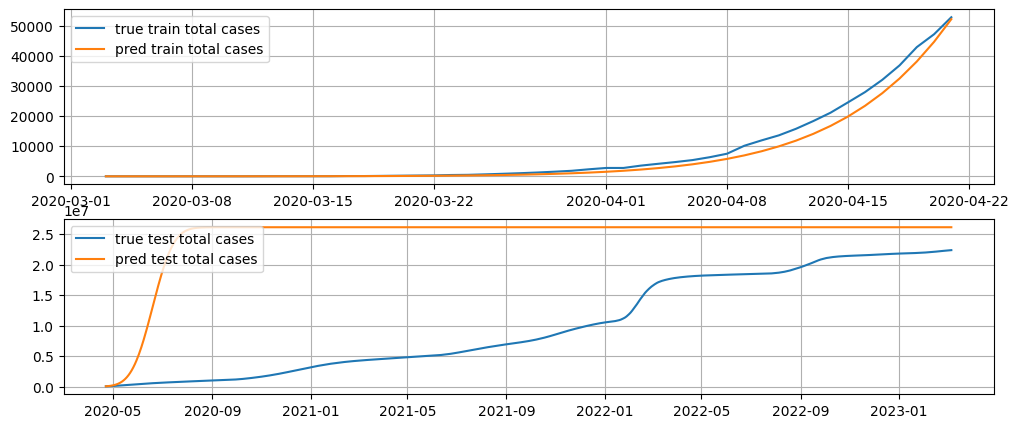

In [300]:
# Plot results
_, ax = plt.subplots(2, 1, figsize=(12, 5))
ax[0].plot(df_train.date, df_train['total_cases'], label="true train total cases")
ax[0].plot(df_train.date, total_cases_pred[:50], label="pred train total cases")
ax[0].grid()
ax[0].legend(loc="upper left")
ax[1].plot(df_test.date, df_test['total_cases'], label="true test total cases")
ax[1].plot(df_test.date, total_cases_pred[50:], label="pred test total cases")
ax[1].grid()
ax[1].legend(loc="upper left")
plt.show()

Найдите апостериорное распределение параметров;  
Значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели.

In [304]:
sigma_noise = np.std(df_train.log_new_cases - new_cases_pred_log[:50]) # Noise variance estimation
mu_0, sigma_0 = np.zeros(3), 100 * np.eye(3) # Normal distribution as a prior of parameters
# A posterior distribution of parameters
mu_n, sigma_n = bayesian_update(mu_0, sigma_0, df_train[["norm_num_days", "sq_norm_num_days"]], df_train.log_new_cases, sigma_noise)

## c)

Посэмплируйте много разных сигмоид из апостериорного распределения

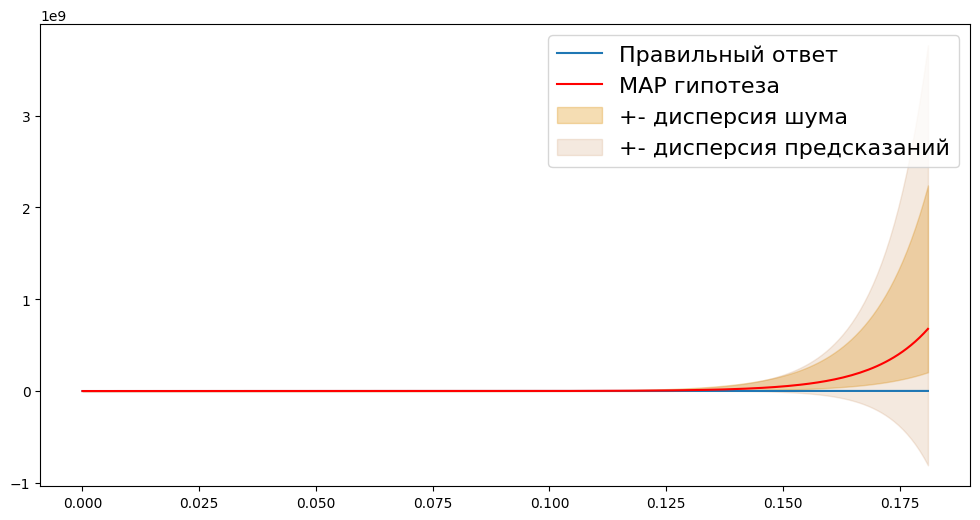

In [305]:
n_samples = 300
num_days = 200
sampled_weights = np.random.multivariate_normal(mu_n, sigma_n, n_samples)
sample_exps = sample_exp_linregs(sampled_weights, df.norm_num_days[:num_days], True)

plot_predictions(df.norm_num_days[:num_days], mu_n, sample_exps, sigma_noise, True)

Постройте эмпирическое предсказательное распределение

In [285]:
def predict_y_dist(date, sampled_weights):
    xs = df[df['date'] <= date].norm_num_days.values
    xs = np.column_stack([np.ones(len(xs)), xs, xs ** 2])
    return np.cumsum(np.exp(sampled_weights @ xs.T), 1)[:, -1]

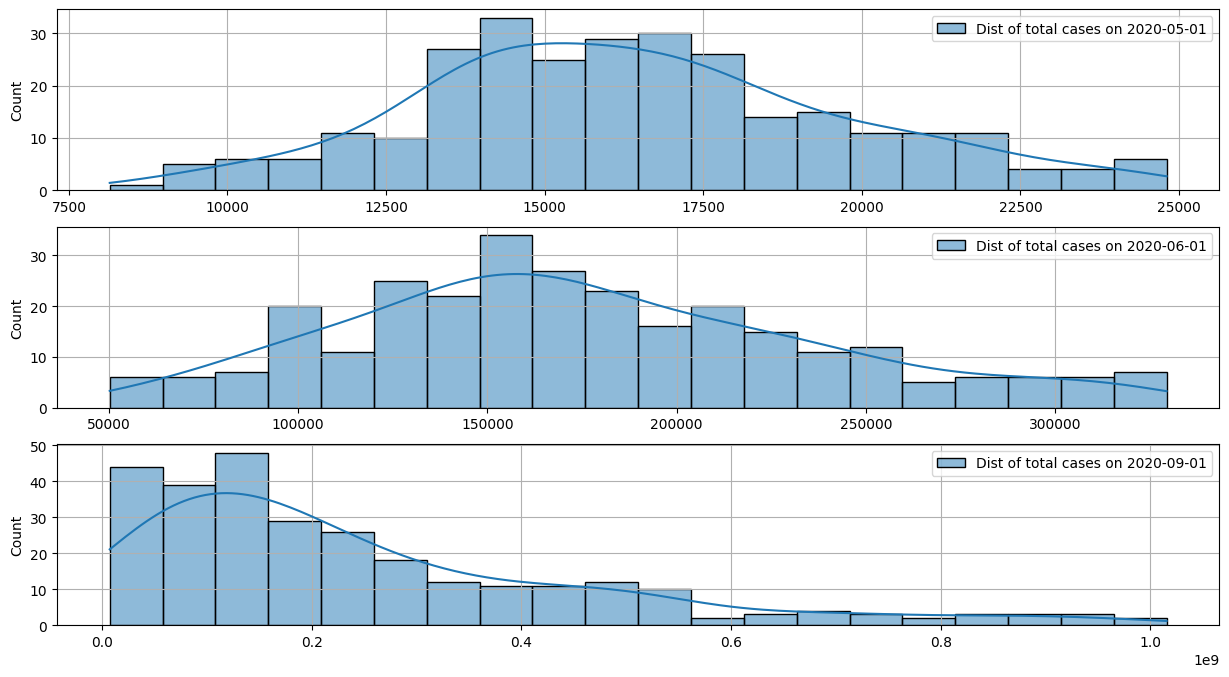

In [288]:
# Total cases and New cases graphs
_, axs = plt.subplots(3, 1, figsize=(15, 8))
date_pred = {}
for i, (date, ax) in enumerate(zip(["2020-05-01", "2020-06-01", "2020-09-01"], axs)):
    date_pred.update({date: predict_y_dist(date, sampled_weights)})
    sns.histplot(date_pred[date][date_pred[date] < np.quantile(date_pred[date], 0.95)], ax=ax, bins=20, kde=True, label=f"Dist of total cases on {date}")
    ax.legend()
    ax.grid(True)
plt.show()

Каков ваш прогноз числа случаев коронавируса в пессимистичном сценарии (90-й процентиль в выборке числа случаев)? В оптимистичном сценарии (10-й процентиль)?

In [291]:
print(f"Случаев заражения в РФ к 01.09.2020 (90-й процентиль): {int(np.quantile(date_pred['2020-09-01'], 0.9))}")
print(f"Случаев заражения в РФ к 01.09.2020 (10-й процентиль): {int(np.quantile(date_pred['2020-09-01'], 0.1))}")
print(f"Случаев заражения в РФ к 01.09.2020 (50-й процентиль): {int(np.quantile(date_pred['2020-09-01'], 0.5))}")
print(f"Реальное количество зараженных к 1.09.2020: {int(df[df.date == '2020-09-01'].total_cases.item())}")

Случаев заражения в РФ к 01.09.2020 (90-й процентиль): 717247496
Случаев заражения в РФ к 01.09.2020 (10-й процентиль): 42274220
Случаев заражения в РФ к 01.09.2020 (50-й процентиль): 191432590
Реальное количество зараженных к 1.09.2020: 1000048
